## Cluster the reviews that you collected in homework 5, by doing the following:

## --- COPY FROM HW5 & HW7 TO GET REVIEWS ---

In [22]:
import warnings
warnings.filterwarnings('ignore')

#pip install if necessary
!pip install bs4
!pip install numpy
!pip install nltk
!pip install vaderSentiment

# package and libary install
import matplotlib
from IPython.display import Image
matplotlib.use('Agg')
from bs4 import BeautifulSoup
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import state_union
from nltk.tag import pos_tag
from nltk.tokenize import PunktSentenceTokenizer
import numpy as np
from operator import itemgetter
import pandas as pd
import requests
import re
from string import punctuation


nltk.download('maxent_treebank_pos_tagger')
nltk.download('treebank')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.options.display.max_colwidth=500

def getSoup(url):
    """
    Utility function which takes a url and returns a Soup object.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    return soup

def minMax(a):
    '''Returns the index of negative and positive review.'''
    
    # get the index of least rated user review
    minpos = a.index(min(a))
    
    # get the index of highest rated user review
    maxpos = a.index(max(a))
    
    return minpos, maxpos

def getReviews(soup):
    '''Function returns a negative and positive review for each movie.'''
    
    # get a list of user ratings
    user_review_ratings = [tag.previous_element for tag in 
                           soup.find_all('span', attrs={'class': 'point-scale'})]
    
    
    # find the index of negative and positive review
    n_index, p_index = minMax(list(map(int, user_review_ratings)))
    
    
    # get the review tags
    user_review_list = soup.find_all('a', attrs={'class':'title'})
    
    
    # get the negative and positive review tags
    n_review_tag = user_review_list[n_index]
    p_review_tag = user_review_list[p_index]
    
    # return the negative and positive review link
    n_review_link = "https://www.imdb.com" + n_review_tag['href']
    p_review_link = "https://www.imdb.com" + p_review_tag['href']
    
    return n_review_link, p_review_link

def getReviewText(review_url):
    '''Returns the user review text given the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find div tags with class text show-more__control
    tag = soup.find('div', attrs={'class': 'text show-more__control'})
    
    return tag.getText()

def getMovieTitle(review_url):
    '''Returns the movie title from the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find h1 tag
    tag = soup.find('h1')
    
    return list(tag.children)[1].getText()

def getNounChunks(user_review):
    
    # create the doc object
    doc = nlp(user_review)
    
    # get a list of noun_chunks
    noun_chunks = list(doc.noun_chunks)
    
    # convert noun_chunks from span objects to strings, otherwise it won't pickle
    noun_chunks_strlist = [chunk.text for chunk in noun_chunks]
    
    return noun_chunks_strlist

# limit to 250 movies
url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=1.0,10.0
    &genres=comedy&view=simple&sort=user_rating,desc&count=250&role=nm0001191'''
# get the soup object for main api url
movies_soup = getSoup(url)

# find all a-tags with class:None
movie_tags = movies_soup.find_all('a', attrs={'class': None})

# filter the a-tags to get just the titles
movie_tags = [tag.attrs['href'] for tag in movie_tags 
              if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]

# remove duplicate links
movie_tags = list(dict.fromkeys(movie_tags))

# movie links
base_url = "https://www.imdb.com"
movie_links = [base_url + tag + 'reviews' for tag in movie_tags]

# get a list of soup objects
movie_soups = [getSoup(link) for link in movie_links]

# get all 500 movie review links
movie_review_list = [getReviews(movie_soup) for movie_soup in movie_soups]
movie_review_list = list(itertools.chain(*movie_review_list))

# get review text from the review link
review_texts = [getReviewText(url) for url in movie_review_list]

# get movie name from the review link
movie_titles = [getMovieTitle(url) for url in movie_review_list]

# construct a dataframe
df = pd.DataFrame({'movie': movie_titles, 'user_review_permalink': movie_review_list, 'user_review': review_texts})

# Convert reviews to a list
review_list = df['user_review'].tolist()

## --- END COPY - BEGIN HW ---

### 1. In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split # split the testing and training sets

vectorizer = TfidfVectorizer(min_df=20, max_df=0.4, max_features=20000, ngram_range=(1,1), stop_words='english')

# calculate the feature matrix
# feature_matrix = vectorizer.fit_transform(review_list)

In [26]:
vds = SentimentIntensityAnalyzer()

sent = []
for x in review_list:
    y = vds.polarity_scores(x)
    sent.append(y)

In [36]:
reviews_sent = list(zip(review_list, sent))

In [133]:
from pandas import DataFrame
df = DataFrame(reviews_sent, columns=['Review', 'Sentiment'])

In [134]:
df['Sentiment'] = df['Sentiment'].astype(str)
df[['neg','neu','pos','compound']] = df['Sentiment'].str.split(', ',expand=True)
del df['Sentiment']
df['neg'].to_string()
df['neu'].to_string()
df['pos'].to_string()
df['compound'].to_string()
df

,Review,neg,neu,pos,compound
0,"Adam Sandler is known for his wacky, flaky, and sometimes over the top style of comedy. With films like Billy Madison, Happy Gilmore, and Big Daddy under his belt, one would think that he would stick with what he's got. Sandler has shown us a new side of him with his performance in Paul Thomas Anderson's Punch Drunk Love.Sandler plays Barry Egan, an ambitious man who owns and operates his own business. He sells his own plungers. One day after finishing a phone call with a food company, he wa...",{'neg': 0.064,'neu': 0.747,'pos': 0.188,'compound': 0.9973}
1,"One of my old English teachers once asked us about a book, ""Did you all like the book? I'm not asking whether you enjoyed it; I don't care. I want to know if you liked it."" She was making an important distinction.I remembered that as I watched Punch-Drunk Love. It's very unusual. The film is set in L.A., but you don't see much scenery indicating that. You see unpleasant things. Adam Sandler's office is long and empty: just seeing him sitting at his desk assaults you with a feeling of lonelin...",{'neg': 0.189,'neu': 0.711,'pos': 0.1,'compound': -0.9962}
2,"My friend and I wanted to go see this for Halloween. We liked the idea of a hotel for monsters. We both hated it. The characters moved in very OTT way and it was distracting. Every shot was a close up on someone's face, I just wanted to push them away from the camera. The jokes weren't funny, it has the typical Adam Sandler toilet jokes that just make me groan. Jonathon was REALLY annoying. He was this films' Jar Jar. But worst of all we have the ""Liar Revealed"" cliché. Dracula pretends this...",{'neg': 0.143,'neu': 0.701,'pos': 0.156,'compound': 0.2321}
3,"I gave this a complete 10 because both the wife and I (as well as the other movie-goers -going by their reactions) thoroughly enjoyed it from the beginning to the very end.Was it predictable? Of course. Its an animation geared towards children (what would you expect?) -but like most of the animation movies of today, there were quite a few 'hidden humor' spots as well which would be completely missed by the younger audience (not unexpected since it is the adults, after all, who are forking ov...",{'neg': 0.025,'neu': 0.778,'pos': 0.197,'compound': 0.9915}
4,"Okay....I feel asleep on the couch and woke up to see this film starting with an old vedio game I use to play with the credits going by. I almost turned it off when I saw Adam Sandler's name, but I thought I'll give it a shot. After all...Shirley Jones is in it, and I have had the hots for Shirley since The Partridge Family days. The episode were Shirley wore hot-pants....very sexy! Ten minutes into the film....I was laughing out loud! How many of us know a headcase like Dante? This movie di...",{'neg': 0.059,'neu': 0.729,'pos': 0.211,'compound': 0.9926}
...,...,...,...,...,...
121,Become another person become another person become another person become another person become another person become another person become another person,{'neg': 0.0,'neu': 1.0,'pos': 0.0,'compound': 0.0}
122,"How does a movie like Bucky Larson get made? Here is a movie that appeals to no audience I can think of, and yet it is playing on thousands of screens. The only logical explanation I can come to for this movie's existence is that Mr. Sandler has some very incriminating photos of someone at Columbia Pictures.Our title hero, Bucky (played by comedian Nick Swardson), is a dweeb. Not a funny one, or a likable one, but a pathetic dweeb who seems to live in his own world. Bucky hails from a small ...",{'neg': 0.121,'neu': 0.749,'pos': 0.129,'compound': 0.6944}
123,"This movie was digusting and unfunny for most of the part. This movie is about a red neck,bucked tooth,goofy kid name Bucky who dreamed of being a pornstar in California after realizing his parents were famous pornstar during the 1970's.He soon became famous for his really small microscopic penis.The worst part was that this movie had a lack 

### 2. For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

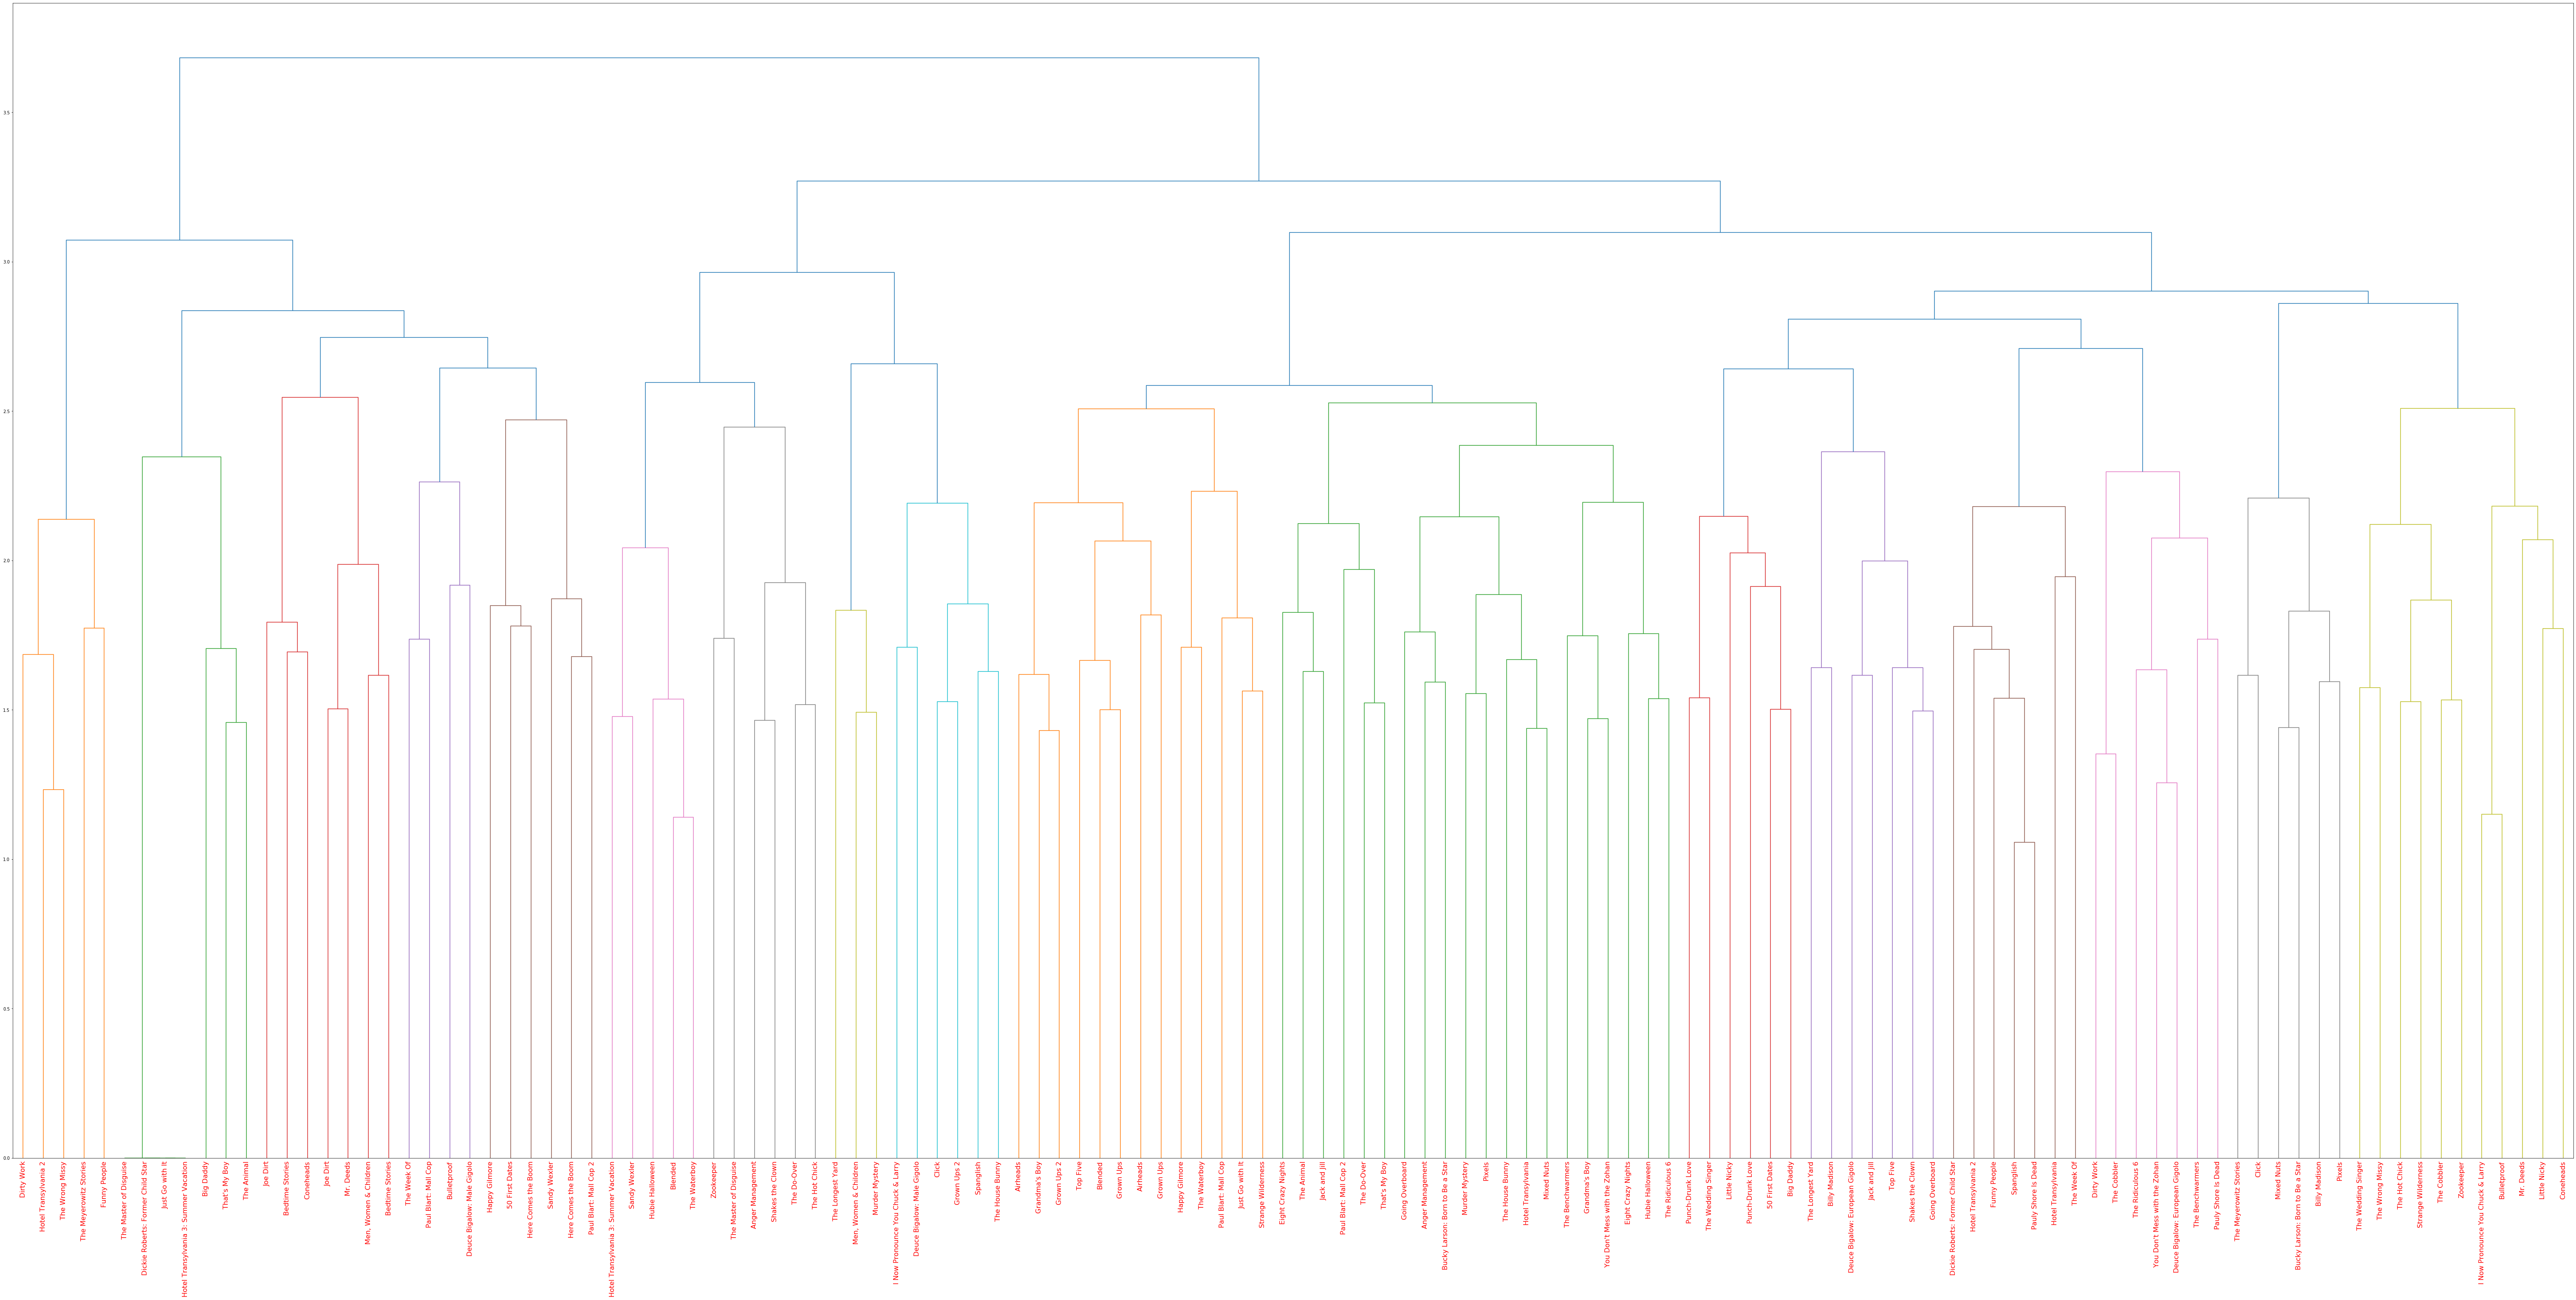

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt


# Import cosine_similarity to calculate similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(feature_matrix)

# Import modules necessary to plot dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

# Create mergings matrix
mergings = linkage(similarity_distance, method='complete')

df2 = pd.DataFrame({'movie': movie_titles,'user_review': review_texts})

# complete linkage 

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings, orientation='top',
               labels=[x for x in df2['movie']],
               leaf_font_size=16
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 50)

# Show the plotted dendrogram
plt.show()

I went through by hand and did this... super tedious but I wanted to see what results came from it. I took the 3 main clusters from the dendogram and here were the results:

Cluster 1: average = 0.654, median = 0.713, high = 0.98, low = 0.05

Cluster 2: average = 0.621, median = 0.756, high = 0.93, low = 0.10

Cluster 3: average = 0.671, median = 0.875, high = 0.97, low = 0.13

I noticed that overall, the vader sentiment analysis reported things as having a neutral sentiment. Looking into the reviews themselves, the sentiment was clearly negative but the sentiment was labeled as neutral. Looking back, this would need to be iterated and adjusted over time. The vader seemed to lean more on the safe side of sentiment analysis.

### 3. or extra credit, analyze sentiment of chunks as follows:
a. Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).

b.Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see. 
